In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import cv2
import random
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps
import nibabel as nib
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf

In [5]:
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
# from tensorflow.keras.layers.experimental import preprocessing

In [11]:
import os

# Kaggle dataset paths
TRAIN_DATASET_PATH = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/"
VAL_DATASET_PATH   = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/"

def preprocess_dataset(dataset_path):
    """
    Preprocess BraTS dataset:
    - Rename segmentation files to *_seg.nii
    - Check that each patient folder contains all required modalities
    """
    required_modalities = ["flair", "t1", "t1ce", "t2", "seg"]
    issues = []  # keep track of missing files

    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)

        # ✅ Only process patient folders (e.g. BraTS20_Training_001)
        if not os.path.isdir(folder_path) or not folder.startswith("BraTS20"):
            continue

        # Step 1: Rename segmentation file if needed
        for file in os.listdir(folder_path):
            if file.endswith("Segm.nii"):  # old naming
                old_path = os.path.join(folder_path, file)
                new_path = os.path.join(folder_path, f"{folder}_seg.nii")
                os.rename(old_path, new_path)
                print(f"Renamed: {old_path} -> {new_path}")

        # Step 2: Verify all modalities exist
        missing = []
        for modality in required_modalities:
            expected_file = os.path.join(folder_path, f"{folder}_{modality}.nii")
            if not os.path.exists(expected_file):
                missing.append(modality)

        if missing:
            issues.append((folder, missing))

    # Print summary
    if issues:
        print("\n⚠️ Some patients are missing files:")
        for patient, missing_mods in issues:
            print(f" - {patient}: missing {missing_mods}")
    else:
        print("\n✅ All patient folders are ready!")

# Run preprocessing
print("Preprocessing Training Data...")
preprocess_dataset(TRAIN_DATASET_PATH)

print("\nPreprocessing Validation Data...")
preprocess_dataset(VAL_DATASET_PATH)


Preprocessing Training Data...

✅ All patient folders are ready!

Preprocessing Validation Data...

✅ All patient folders are ready!


In [17]:
TRAIN_DATASET_PATH = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
VAL_DATASET_PATH   = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/"


In [15]:
import os

print("Training Root:", TRAIN_DATASET_PATH)
print(os.listdir(TRAIN_DATASET_PATH))  # list top-level folders


Training Root: /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/
['MICCAI_BraTS2020_TrainingData']


In [18]:
import os

print(os.listdir(TRAIN_DATASET_PATH)[:10])  # show first 10 patients


['BraTS20_Training_083', 'BraTS20_Training_337', 'BraTS20_Training_161', 'BraTS20_Training_198', 'BraTS20_Training_284', 'BraTS20_Training_169', 'BraTS20_Training_157', 'BraTS20_Training_073', 'BraTS20_Training_253', 'BraTS20_Training_026']


In [21]:
import os

patient_id = "BraTS20_Training_083"
patient_path = os.path.join(TRAIN_DATASET_PATH, patient_id)

print("Files inside", patient_path)
print(os.listdir(patient_path))


Files inside /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_083
['BraTS20_Training_083_flair.nii', 'BraTS20_Training_083_t1.nii', 'BraTS20_Training_083_seg.nii', 'BraTS20_Training_083_t2.nii', 'BraTS20_Training_083_t1ce.nii']


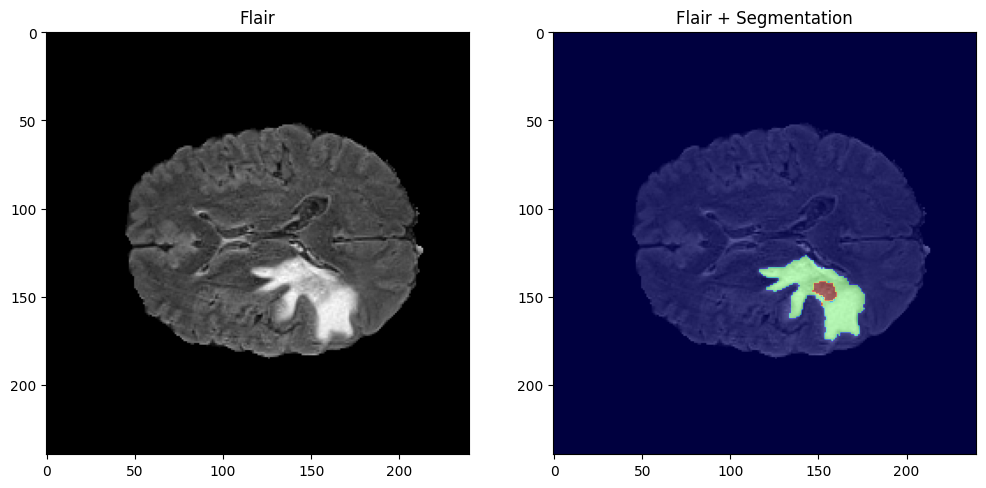

In [22]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os

# pick a patient that exists
patient_id = "BraTS20_Training_083"
patient_path = os.path.join(TRAIN_DATASET_PATH, patient_id)

# load Flair + Segmentation
flair_img = nib.load(os.path.join(patient_path, f"{patient_id}_flair.nii"))
seg_img   = nib.load(os.path.join(patient_path, f"{patient_id}_seg.nii"))

flair_data = flair_img.get_fdata()
seg_data   = seg_img.get_fdata()

# middle slice
slice_idx = flair_data.shape[2] // 2

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(flair_data[:,:,slice_idx], cmap="gray")
plt.title("Flair")

plt.subplot(1,2,2)
plt.imshow(flair_data[:,:,slice_idx], cmap="gray")
plt.imshow(seg_data[:,:,slice_idx], alpha=0.5, cmap="jet")  # overlay segmentation
plt.title("Flair + Segmentation")

plt.show()


In [23]:
# load .nii file as a numpy array
test_image_flair = nib.load(TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_flair.nii").get_fdata()
print("Shape: ", test_image_flair.shape)
print("Dtype: ", test_image_flair.dtype)

Shape:  (240, 240, 155)
Dtype:  float64


In [24]:
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Min:  0.0
Max:  1854.603271484375


In [26]:
scaler = MinMaxScaler()

In [27]:
# Scale the test_image_flair array and then reshape it back to its original dimensions.
# This ensures the data is normalized/standardized for model input without altering its spatial structure.
test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

In [28]:
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Min:  0.0
Max:  1.0


In [35]:
# rescaling t1
test_image_t1 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_034/BraTS20_Training_034_t1.nii').get_fdata()
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

# rescaling t1ce
test_image_t1ce = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_034/BraTS20_Training_034_t1ce.nii').get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

# rescaling t2
test_image_t2 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_034/BraTS20_Training_034_t2.nii').get_fdata()
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

# we will not rescale the mask
test_image_seg = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_034/BraTS20_Training_034_seg.nii').get_fdata()

Slice Number: 95


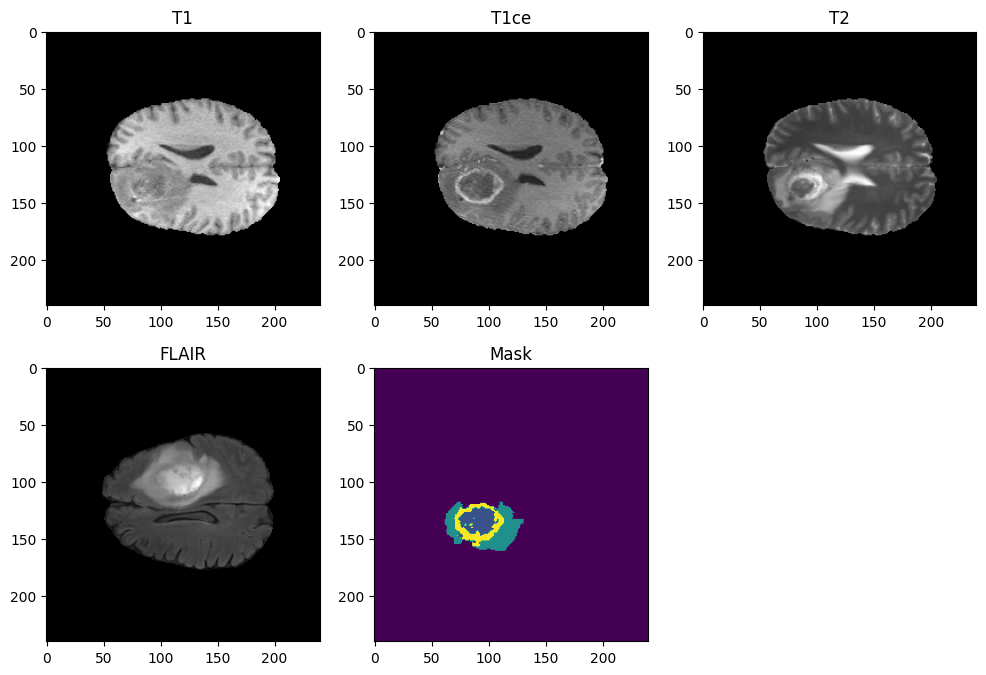

In [36]:
slice = 95

print("Slice Number: " + str(slice))

plt.figure(figsize=(12, 8))

# T1
plt.subplot(2, 3, 1)
plt.imshow(test_image_t1[:,:,slice], cmap='gray')
plt.title('T1')

# T1ce
plt.subplot(2, 3, 2)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1ce')
# T2
plt.subplot(2, 3, 3)
plt.imshow(test_image_t2[:,:,slice], cmap='gray')
plt.title('T2')

# Flair
plt.subplot(2, 3, 4)
plt.imshow(test_image_flair[:,:,slice], cmap='gray')
plt.title('FLAIR')

# Mask
plt.subplot(2, 3, 5)
plt.imshow(test_image_seg[:,:,slice])
plt.title('Mask')
plt.show()



In [37]:
# Modality shape
print("Modality: ", test_image_t1.shape)

# Segmentation shape
print("Segmentation: ", test_image_seg.shape)

Modality:  (240, 240, 155)
Segmentation:  (240, 240, 155)


Slice number: 95


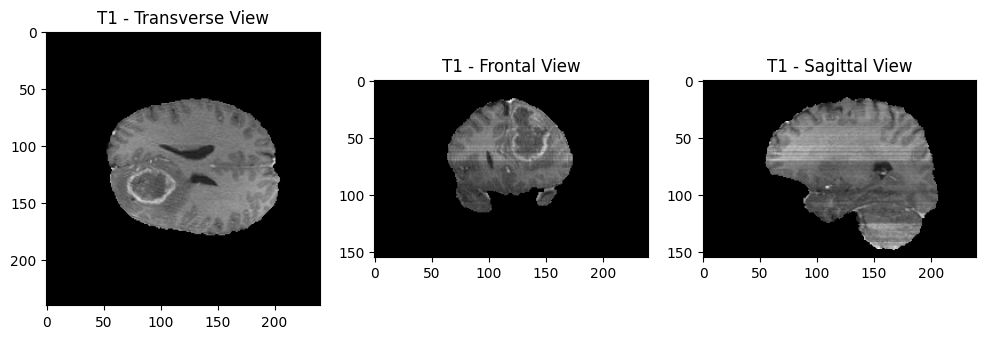

In [38]:
slice = 95

print("Slice number: " + str(slice))

plt.figure(figsize=(12, 8))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
# T1 - Transverse View
plt.subplot(1, 3, 1)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1 - Transverse View')

# T1 - Frontal View
plt.subplot(1, 3, 2)
plt.imshow(rotate(test_image_t1ce[:,slice,:], 90, resize=True), cmap='gray')
plt.title('T1 - Frontal View')

# T1 - Sagittal View
plt.subplot(1, 3, 3)
plt.imshow(rotate(test_image_t1ce[slice,:,:], 90, resize=True), cmap='gray')
plt.title('T1 - Sagittal View')
plt.show()

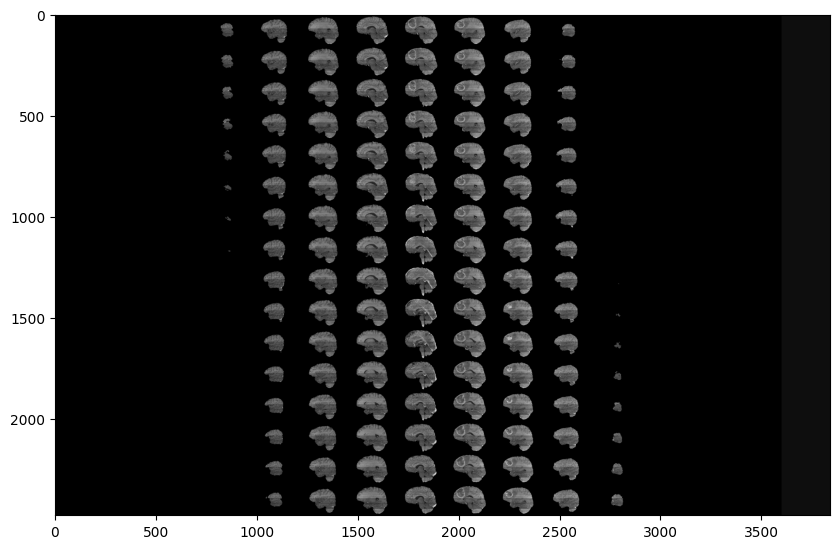

In [39]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)

# montage allows us to concatenate multiple images of the same size horizontally and vertically
plt.imshow(rotate(montage(test_image_t1ce[:,:,:]), 90, resize=True), cmap ='gray');

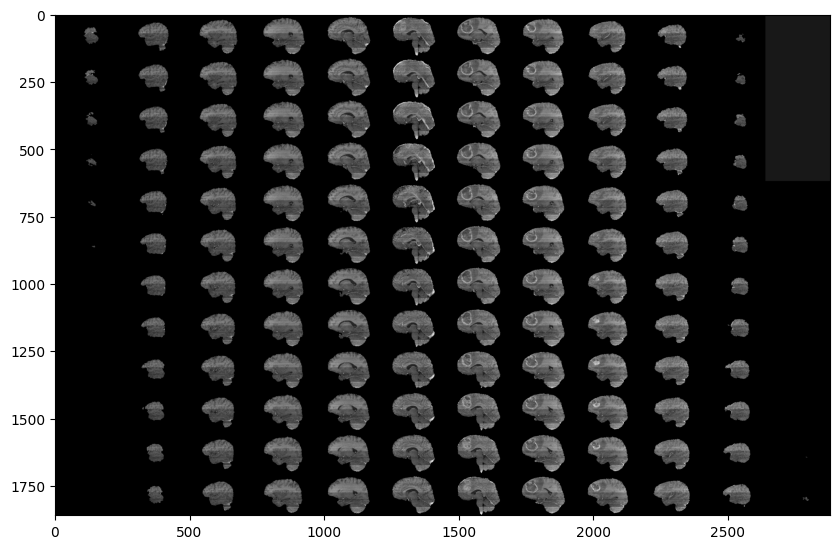

In [40]:
# Skip 50:-50 slices since there is not much to see
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.imshow(rotate(montage(test_image_t1ce[50:-50,:,:]), 90, resize=True), cmap ='gray');

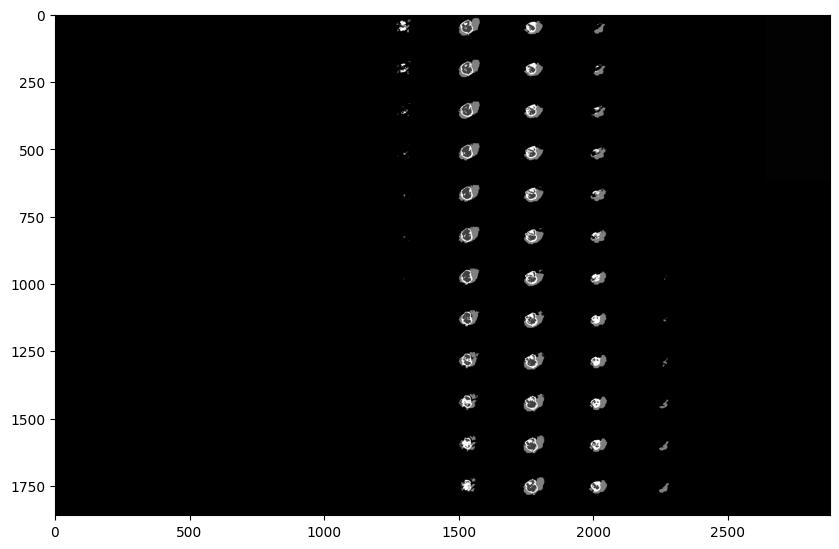

In [41]:
# Skip 50:-50 slices since there is not much to see
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.imshow(rotate(montage(test_image_seg[50:-50,:,:]), 90, resize=True), cmap ='gray');


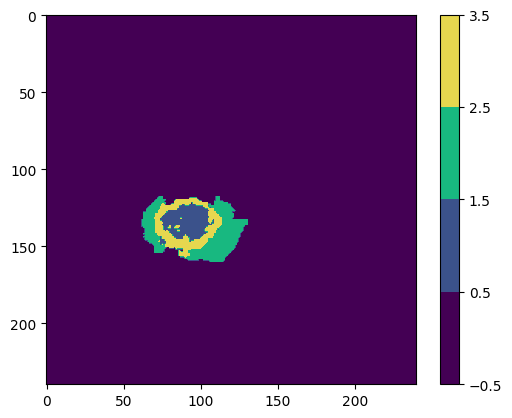

In [42]:
# Plotting the segmantation
cmap = matplotlib.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

# plotting the 95th slice
plt.imshow(test_image_seg[:,:,95], cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

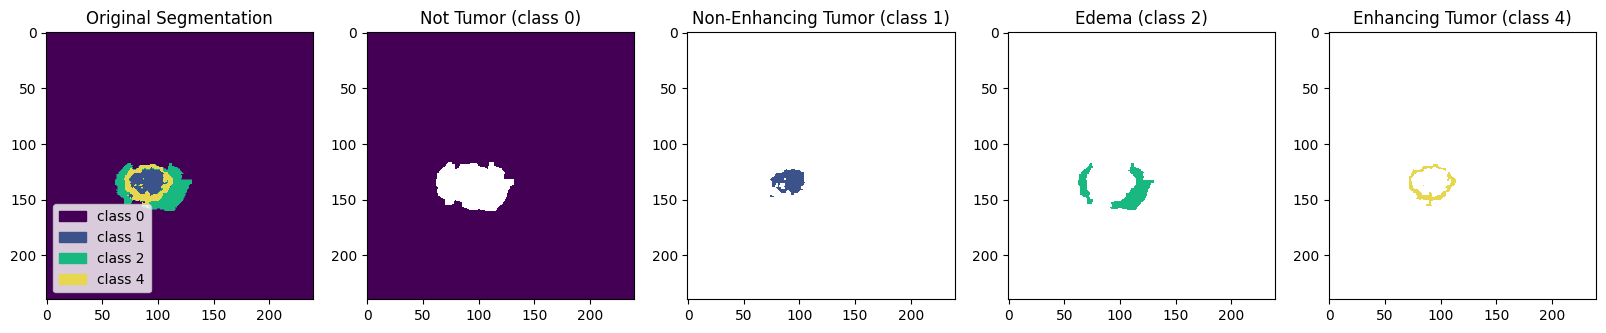

In [43]:
# Isolation of class 0
seg_0 = test_image_seg.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = test_image_seg.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = test_image_seg.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_4 = test_image_seg.copy()
seg_4[seg_4 != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 4']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]
fig, ax = plt.subplots(1, 5, figsize=(20, 20))

ax[0].imshow(test_image_seg[:,:, slice], cmap=cmap, norm=norm)
ax[0].set_title('Original Segmentation')
ax[0].legend(handles=legend, loc='lower left')

ax[1].imshow(seg_0[:,:, slice], cmap=cmap, norm=norm)
ax[1].set_title('Not Tumor (class 0)')

ax[2].imshow(seg_1[:,:, slice], cmap=cmap, norm=norm)
ax[2].set_title('Non-Enhancing Tumor (class 1)')

ax[3].imshow(seg_2[:,:, slice], cmap=cmap, norm=norm)
ax[3].set_title('Edema (class 2)')

ax[4].imshow(seg_4[:,:, slice], cmap=cmap, norm=norm)
ax[4].set_title('Enhancing Tumor (class 4)')

plt.show()

In [44]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);

train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [45]:
# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(train_ids)}")
print(f"Validation length: {len(val_ids)}")
print(f"Test length: {len(test_ids)}")

Train length: 250
Validation length: 74
Test length: 45


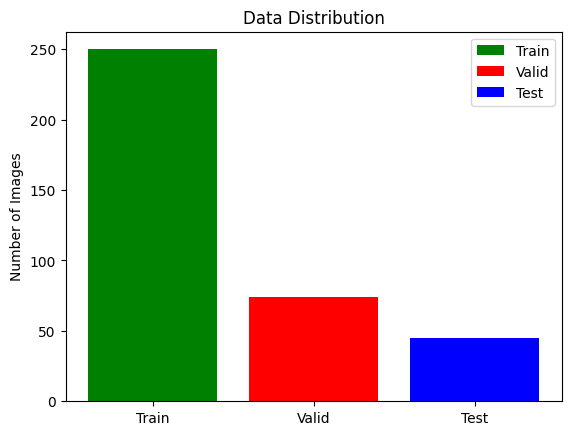

In [46]:
plt.bar(["Train","Valid","Test"],
        [len(train_ids), len(val_ids), len(test_ids)],
        align='center',
        color=[ 'green','red', 'blue'],
        label=["Train", "Valid", "Test"]
       )

plt.legend()

plt.ylabel('Number of Images')
plt.title('Data Distribution')

plt.show()

In [47]:
# Define seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3
}

# Select Slices and Image Size
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include
IMG_SIZE=128

In [60]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

        # Dictionary for exceptions (misnamed segmentation files)
        self.seg_exceptions = {
            "BraTS20_Training_355": "W39_1998.09.19_Segm.nii"
        }

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))

        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            # Load modalities
            flair = nib.load(os.path.join(case_path, f"{i}_flair.nii")).get_fdata()
            t1ce  = nib.load(os.path.join(case_path, f"{i}_t1ce.nii")).get_fdata()

            # Handle segmentation path
            seg_path = os.path.join(case_path, f"{i}_seg.nii")
            if not os.path.exists(seg_path) and i in self.seg_exceptions:
                seg_path = os.path.join(case_path, self.seg_exceptions[i])
            seg = nib.load(seg_path).get_fdata()

            # Fill arrays
            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES*c, :, :, 0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES*c, :, :, 1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                y[j + VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]

        # Fix labels (replace 4→3)
        y[y==4] = 3

        # One-hot encode & resize
        mask = tf.one_hot(y, 4)
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))

        return X/np.max(X), Y


I0000 00:00:1755354816.048244      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


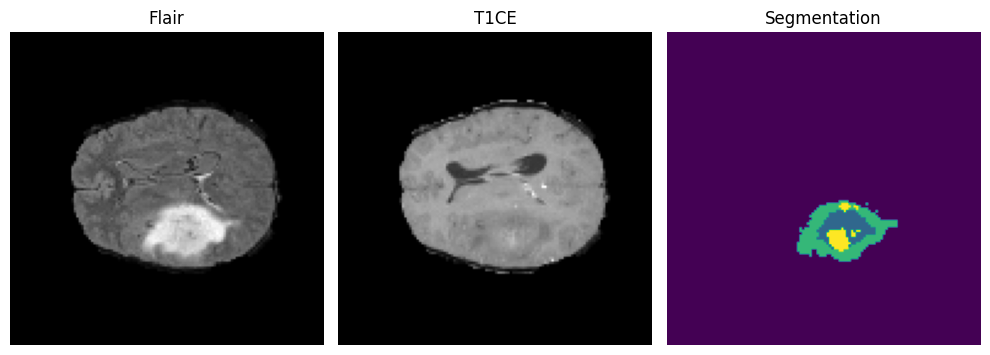

In [49]:
# Define a function to display one slice and its segmentation
def display_slice_and_segmentation(flair, t1ce, segmentation):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    axes[0].imshow(flair, cmap='gray')
    axes[0].set_title('Flair')
    axes[0].axis('off')

    axes[1].imshow(t1ce, cmap='gray')
    axes[1].set_title('T1CE')
    axes[1].axis('off')

    axes[2].imshow(segmentation) # Displaying segmentation
    axes[2].set_title('Segmentation')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()
    # Retrieve the batch from the training generator
X_batch, Y_batch = training_generator[8]

# Extract Flair, T1CE, and segmentation from the batch
flair_batch = X_batch[:, :, :, 0]
t1ce_batch = X_batch[:, :, :, 1]
segmentation_batch = np.argmax(Y_batch, axis=-1)  # Convert one-hot encoded to categorical

# Extract the 50th slice from Flair, T1CE, and segmentation
slice_index = 60  # Indexing starts from 0
slice_flair = flair_batch[slice_index]
slice_t1ce = t1ce_batch[slice_index]
slice_segmentation = segmentation_batch[slice_index]

# Display the 50th slice and its segmentation
display_slice_and_segmentation(slice_flair, slice_t1ce, slice_segmentation)

In [66]:
import tensorflow as tf

# Dice coefficient
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    total_loss = 0
    for i in range(class_num):
        # Flatten tensors
        y_true_f = tf.reshape(y_true[:, :, :, i], [-1])
        y_pred_f = tf.reshape(y_pred[:, :, :, i], [-1])
        
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        loss = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
        
        total_loss += loss

    total_loss = total_loss / class_num
    return total_loss

# Dice loss (to minimize)
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


In [52]:
# Define per class evaluation of dice coef
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)

In [53]:
# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [76]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)


In [85]:
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing])

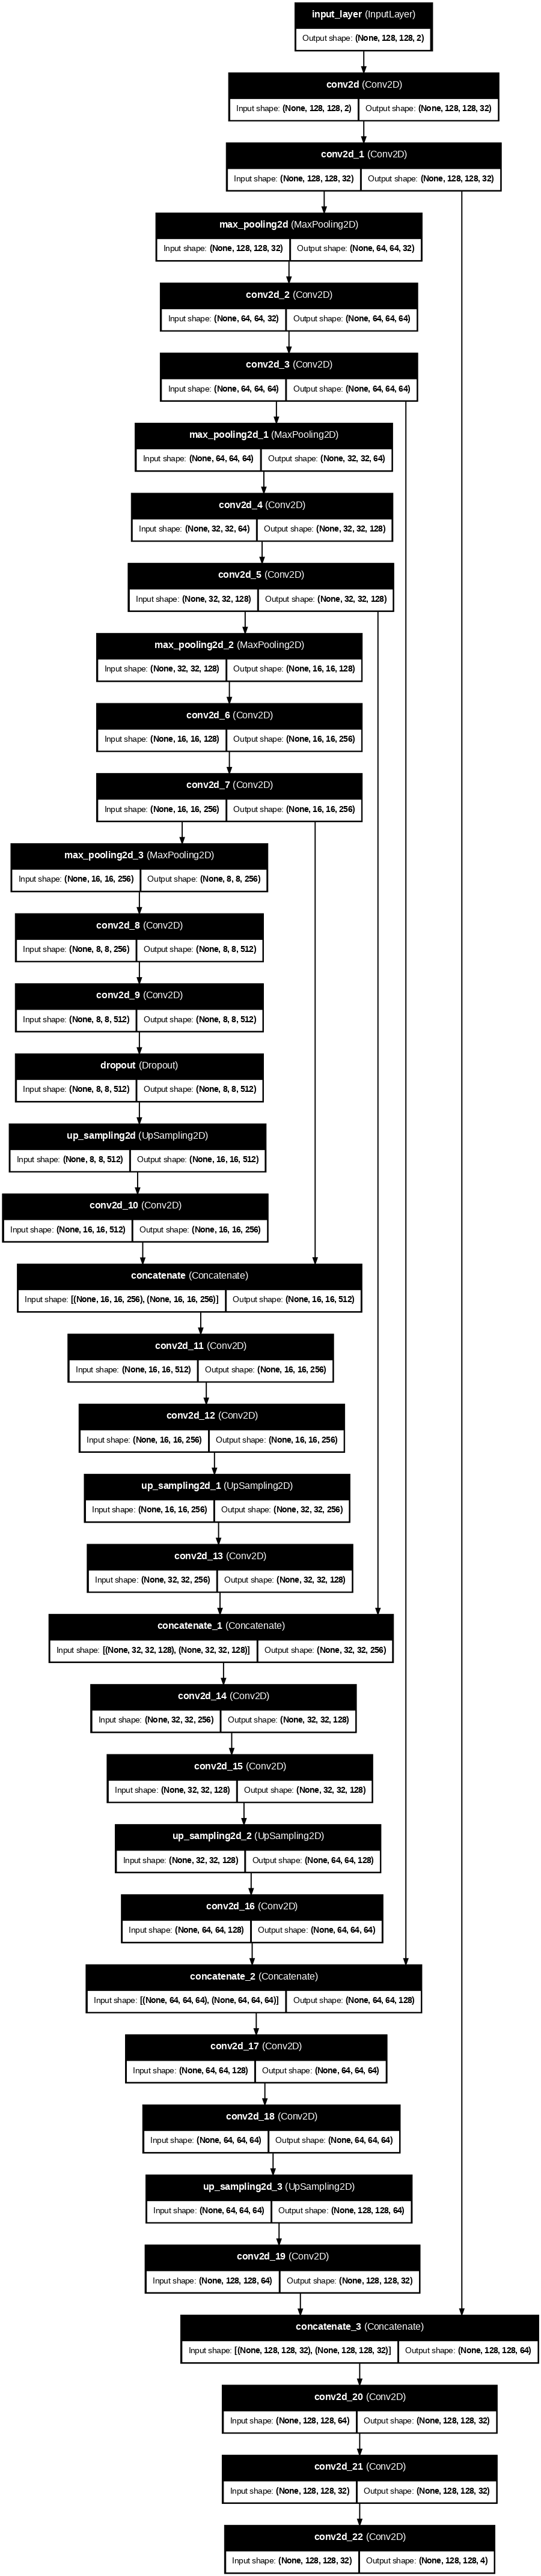

In [86]:
plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

In [87]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.000001,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath = 'model_.{epoch:02d}-{val_loss:.6f}.weights.h5',
        verbose=1,
        save_best_only=True,
        save_weights_only=True
    ),
    CSVLogger('training.log', separator=',', append=False)
]


In [89]:
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator  = DataGenerator(test_ids)


In [90]:
# Combined loss: categorical crossentropy + dice loss
def combined_loss(y_true, y_pred):
    ce = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
    dl = dice_loss(y_true, y_pred)
    return ce + dl

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=combined_loss,
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)


In [92]:
K.clear_session()

history =  model.fit(training_generator,
                    epochs=35,
                    steps_per_epoch=len(train_ids),
                    callbacks= callbacks,
                    validation_data = valid_generator
                    )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.9631 - dice_coef: 0.2600 - dice_coef_edema: 0.1180 - dice_coef_enhancing: 0.0672 - dice_coef_necrotic: 0.0638 - loss: 0.9810 - mean_io_u_1: 0.5401 - precision: 0.9394 - sensitivity: 0.9042 - specificity: 0.9944
Epoch 1: val_loss improved from inf to 0.69831, saving model to model_.01-0.698309.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 130s 442ms/step - accuracy: 0.9631 - dice_coef: 0.2601 - dice_coef_edema: 0.1183 - dice_coef_enhancing: 0.0675 - dice_coef_necrotic: 0.0640 - loss: 0.9804 - mean_io_u_1: 0.5404 - precision: 0.9396 - sensitivity: 0.9044 - specificity: 0.9944 - val_accuracy: 0.9837 - val_dice_coef: 0.3568 - val_dice_coef_edema: 0.3338 - val_dice_coef_enhancing: 0.3206 - val_dice_coef_necrotic: 0.1939 - val_loss: 0.6983 - val_mean_io_u_1: 0.6554 - val_precision: 0.9892 - val_sensitivity: 0.9799 - val_specificity: 0.9963 - learning_rate: 1.0000e-04
Epoch 2/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy

In [94]:
# Save in native Keras format (recommended)
model.save("brain_tumor_model.keras")

# Or save in HDF5 format (compatible with older Keras)
model.save("brain_tumor_model.h5")

# If you want SavedModel for TF Serving or TFLite
model.export("brain_tumor_model")


Saved artifact at 'brain_tumor_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 2), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 128, 128, 4), dtype=tf.float32, name=None)
Captures:
  136290325731024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136290325741392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136290325738704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136290325736208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136290325725840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136290325729488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136290325737552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136290325727568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136290322467344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136290322480400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136

In [ ]:
import shutil

shutil.make_archive("/kaggle/working/brain_tumor_model", 'zip', "/kaggle/working/brain_tumor_model")


In [96]:
# Save in Keras native format
model.save("/kaggle/working/brain_tumor_model.keras")


In [99]:
from IPython.display import FileLink

# Create a clickable download link for your zip file
FileLink("/kaggle/working/brain_tumor_model.zip")


/kaggle/working/brain_tumor_model.zip

In [102]:
import os
os.listdir("/kaggle/working/")


['model_.22-0.353848.weights.h5',
 'model_.26-0.353299.weights.h5',
 'model_.17-0.385914.weights.h5',
 'model_.05-0.529222.weights.h5',
 'brain_tumor_model.keras',
 'model_.02-0.638895.weights.h5',
 'brain_tumor_model.zip',
 'model.png',
 'model_.15-0.389626.weights.h5',
 'model_.03-0.607895.weights.h5',
 'training.log',
 'model_.10-0.436955.weights.h5',
 'model_.11-0.415636.weights.h5',
 'model_.06-0.512071.weights.h5',
 'my_model.keras',
 'model_.14-0.392765.weights.h5',
 'model_.04-0.538648.weights.h5',
 'model_.12-0.403342.weights.h5',
 'model_.09-0.459935.weights.h5',
 'model_.08-0.465583.weights.h5',
 'model_.20-0.360558.weights.h5',
 'model_.01-0.734121.weights.h5',
 'model_.23-0.353846.weights.h5',
 'model_.07-0.509876.weights.h5',
 'model_.21-0.358939.weights.h5',
 'brain_tumor_model.h5',
 'model_.13-0.394487.weights.h5',
 'model_.04-0.734121.weights.h5',
 'brain_tumor_model',
 'model_.01-0.698309.weights.h5']

In [104]:
from IPython.display import HTML

# For the full zip
file_path = "/kaggle/working/brain_tumor_model.hp"
HTML(f'<a href="{file_path}" download>Click here to download the model</a>')


In [105]:
# This will create brain_tumor_model.zip in the same working directory
shutil.make_archive('/kaggle/working/brain_tumor_model', 'zip', root_dir='/kaggle/working/', base_dir='brain_tumor_model.h5')

'/kaggle/working/brain_tumor_model.zip'

In [107]:
from IPython.display import FileLink

# Clickable link
FileLink('/kaggle/working/brain_tumor_model.h5')


/kaggle/working/brain_tumor_model.h5

In [111]:
# Or save in HDF5 format (compatible with older Keras)
model.save("brain_tumor_model1.h5")

In [112]:
import zipfile

# Path to your model file
file_path = '/kaggle/working/brain_tumor_model1.h5'
zip_path = '/kaggle/working/brain_tumor_model1.zip'

# Create a zip containing that single file
with zipfile.ZipFile(zip_path, 'w') as zipf:
    zipf.write(file_path, arcname='brain_tumor_model1.h5')


In [109]:
import os
os.listdir('/kaggle/working/')


['model_.22-0.353848.weights.h5',
 'model_.26-0.353299.weights.h5',
 'model_.17-0.385914.weights.h5',
 'model_.05-0.529222.weights.h5',
 'brain_tumor_model.keras',
 'model_.02-0.638895.weights.h5',
 'brain_tumor_model.zip',
 'model.png',
 'model_.15-0.389626.weights.h5',
 'model_.03-0.607895.weights.h5',
 'training.log',
 'model_.10-0.436955.weights.h5',
 'model_.11-0.415636.weights.h5',
 'model_.06-0.512071.weights.h5',
 'my_model.keras',
 'model_.14-0.392765.weights.h5',
 'model_.04-0.538648.weights.h5',
 'model_.12-0.403342.weights.h5',
 'model_.09-0.459935.weights.h5',
 'model_.08-0.465583.weights.h5',
 'model_.20-0.360558.weights.h5',
 'model_.01-0.734121.weights.h5',
 'model_.23-0.353846.weights.h5',
 'model_.07-0.509876.weights.h5',
 'model_.21-0.358939.weights.h5',
 'brain_tumor_model.h5',
 'model_.13-0.394487.weights.h5',
 'model_.04-0.734121.weights.h5',
 'brain_tumor_model',
 'model_.01-0.698309.weights.h5']

In [113]:
import kagglehub

kagglehub.login()

# Replace with path to directory containing model files.
LOCAL_MODEL_DIR = '/kaggle/working/brain_tumor_model'

MODEL_SLUG = 'brain_tumor_model' # Replace with model slug.

# Learn more about naming model variations at
# https://www.kaggle.com/docs/models#name-model.
VARIATION_SLUG = 'default' # Replace with variation slug.

kagglehub.model_upload(
  handle = f"laibaidrees/{MODEL_SLUG}/keras/{VARIATION_SLUG}",
  local_model_dir = LOCAL_MODEL_DIR,
  version_notes = 'Update 2025-08-16')

Uploading Model https://www.kaggle.com/models/laibaidrees/my_model/keras/default ...
Model 'my_model' does not exist or access is forbidden for user 'laibaidrees'. Creating or handling Model...
Model 'my_model' Created.
Starting upload for file /kaggle/working/brain_tumor_model/saved_model.pb


Uploading: 100%|██████████| 327k/327k [00:00<00:00, 1.55MB/s]

Upload successful: /kaggle/working/brain_tumor_model/saved_model.pb (319KB)
Starting upload for file /kaggle/working/brain_tumor_model/fingerprint.pb



Uploading: 100%|██████████| 57.0/57.0 [00:00<00:00, 313B/s]

Upload successful: /kaggle/working/brain_tumor_model/fingerprint.pb (57B)
Starting upload for file /kaggle/working/brain_tumor_model/variables/variables.data-00000-of-00001



Uploading: 100%|██████████| 62.1M/62.1M [00:00<00:00, 110MB/s]

Upload successful: /kaggle/working/brain_tumor_model/variables/variables.data-00000-of-00001 (59MB)
Starting upload for file /kaggle/working/brain_tumor_model/variables/variables.index



Uploading: 100%|██████████| 5.74k/5.74k [00:00<00:00, 32.8kB/s]

Upload successful: /kaggle/working/brain_tumor_model/variables/variables.index (6KB)


Your model instance has been created.
Files are being processed...
See at: https://www.kaggle.com/models/laibaidrees/my_model/keras/default
